In theory, neural networks with only one hidden layer are capable of approximating any continuous function. In practice, this can require a huge number of hidden neurons, making the network inefficient. This is very similar to the universality of $NAND$ or $XOR$ gates: though they are sufficient to represent any logical formula up to equivalence, they lead to formulae so long that they are not amenable to practical applications.

Nielsen gives an [example](https://eccc.weizmann.ac.il//report/2012/137/) of such inefficiencies. True, we were able to surpass $98$% accuracy on $MNIST$ with just one hidden layer. However, this did take some work (*cf* [Chapter 3](http://localhost:8888/notebooks/Desktop/Python%20Tutorials/NNDL/Chapter%203.1%20-%20Improving%20the%20way%20neural%20networks%20learn.ipynb)), and it seems pretty plausible that deeper networks could be more powerful, in particular because they could encode a hierarchical structure, with layers encoding more abstract concepts as they get nearer to the output layer.

As we shall see, training deeper networks is harder than just applying the vanilla $SGD$+Backpropagation method we implemented in the previous chapters. In particular, the speed of learning is unevenly distributed between layers. It will often be the case that we will find ourselves in either one of the two following situations:
* learning is very **fast** in the **later** layers while the parameters associated with **early** layers tend to get **stuck**: this is the **vanishing gradient problem**.
* learning is very **fast** in the **early** layers while the parameters associated with **later** layers tend to get **stuck**: this is the **exploding gradient problem**.


# I. The vanishing gradient problem

Let's first observe that deep networks don't always perform better. Once again, I copy-pasted the code for ``network2.py``

In [7]:
#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt 

In [8]:
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

In [9]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

In [10]:
#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
            print
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()


In [11]:
#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net



In [12]:
#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [13]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


In [14]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


As always to import the data I had to tinker a little bit with the code so that it would work in Python 3:
* changed ``cPickle`` into ``Pickle``
* converted ``test_data``, ``validation_data``, and ``training_data`` into lists for them to be iterable

In [15]:
#### Libraries
# Standard library
import pickle
import gzip

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('NNDL_file/data/mnist.pkl.gz')
    training_data, validation_data, test_data = pickle.load(f,encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

With one hidden layers:

In [16]:
training_data, validation_data, test_data = load_data_wrapper()
test_data = list(test_data)
validation_data = list(validation_data)
training_data = list(training_data)



net = Network([784, 30, 10]) 
net.SGD(training_data, 30, 10, 0.1, lmbda=5.0, evaluation_data=validation_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9286 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9390 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9466 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9517 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9511 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9532 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9552 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9579 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9535 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9595 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9553 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9584 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9594 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9571 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9286,
  9390,
  9466,
  9517,
  9511,
  9532,
  9552,
  9579,
  9535,
  9595,
  9553,
  9584,
  9594,
  9571,
  9616,
  9601,
  9606,
  9586,
  9604,
  9586,
  9613,
  9597,
  9623,
  9612,
  9632,
  9600,
  9602,
  9604,
  9597,
  9606],
 [],
 [])

With two hidden layers:

In [17]:
 net = Network([784, 30, 30, 10])
net.SGD(training_data, 30, 10, 0.1, lmbda=5.0, evaluation_data=validation_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9208 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9420 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9535 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9563 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9599 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9576 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9601 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9642 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9650 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9650 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9632 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9672 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9628 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9653 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9208,
  9420,
  9535,
  9563,
  9599,
  9576,
  9601,
  9642,
  9650,
  9650,
  9632,
  9672,
  9628,
  9653,
  9681,
  9659,
  9665,
  9675,
  9678,
  9678,
  9693,
  9668,
  9659,
  9684,
  9650,
  9671,
  9681,
  9672,
  9692,
  9675],
 [],
 [])

With three hidden layers:

In [18]:
net = Network([784, 30, 30, 30, 30, 10])
net.SGD(training_data, 30, 10, 0.1, lmbda=5.0, evaluation_data=validation_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 2374 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 8298 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9105 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9242 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9363 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9490 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9466 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9519 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9530 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9547 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9554 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9506 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9518 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9532 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [2374,
  8298,
  9105,
  9242,
  9363,
  9490,
  9466,
  9519,
  9530,
  9547,
  9554,
  9506,
  9518,
  9532,
  9590,
  9580,
  9603,
  9622,
  9658,
  9584,
  9616,
  9654,
  9642,
  9624,
  9655,
  9653,
  9644,
  9617,
  9629,
  9642],
 [],
 [])

In the previous example, adding identical hidden layers doesn't always improve, and can even decrease network accuracy ! This is very counter-intuitive: surely adding layers can't hurt ? After all, they make the network more powerful (without impeding regularization), right ? So what's going here ?

If we take a look at the partial derivatives $\frac {\partial C} {\partial b}$ of the cost with respect to the bias of each neuron (which, by **(BP3)**, are also equal to the rate of change of $C$ with respect to the weighted input), we observe a striking discrepancy. For a network with $2$ hidden layers, the absolute values of the partial derivatives at the start of learning is much greater in later neurons than in early neurons.

Michael calls **gradient** of the $j^{th}$ neuron of the $l^{th}$ layer what we previously referred to as the error, $\delta^l_j = \frac {\partial C} {\partial b^l_j}$. The norm $||\delta^l||$ measures the speed at which the $l^{th}$ layer is learning. In our $2$ layer example, $||\delta^1||$ is much smaller than $||\delta^2||$. This patern holds when we increase the number of hidden layers, and when we measure $||\delta^l||$ at different dates during learning.

Avoiding the vanishing problem leads to fall into the opposite extreme: the **exploding gradient problem**, where earlier gradients are much bigger (in absolute value) then later gradients. This general problem is what we call the network's **instability**.

Maybe a vanishing gradient is what we want: after all, isn't it a necessary condition for the minimum of a differentiable function that it's gradient vanish ? Maybe the gradient's small values correspond to the network's having converged ? Unfortunately, we know this not to be the case: a vanishing gradient is far from sufficient for minimization problems, and it's pretty easy to see that the vanishing gradient problem impedes efficient learning in deep neural nets.




# II. What's causing the vanishing gradient problem? Unstable gradients in deep neural nets


We start with a toy deep network: every layer $j$ has only one neuron with biases $b_j$ and weights $w_j$. We also keep the usual notations for $\delta^j$, $a^j$ and $z^j$.

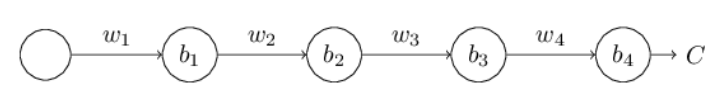

We're interested in the gradient (aka error) $\delta^1$, which we know to be equal to $\frac {\partial C} {\partial b_1}$. Applying the chain rule leads to:

$$\frac {\partial C} {\partial b_1} = \sigma'(z_1)\times w_2 \times \sigma'(z_2)\times w_3 \times \sigma'(z_3)\times w_4 \times \sigma'(z_4)\times \frac {\partial C} {\partial a_4}$$

Understanding $\sigma'$ is therefore going to be useful if we want to know why the gradient vanishes. We already gave the code for $\sigma$ and $\sigma'$ above, in the methods ``sigmoid`` and ``sigmoid_prime``

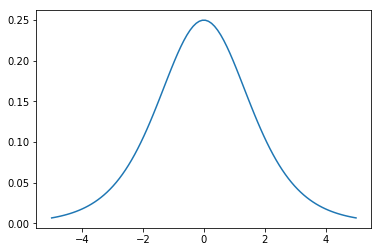

In [19]:
x_axis = np.linspace(-5, 5, 100)
sig = sigmoid_prime(x_axis)

plt.plot(x_axis, sig)

The main takeaway here is that $|\sigma'(x)| \leq 0.25$ for any $x \in \mathbb{R}$. Training begins with weights set according to a normal distribution with standard error $\frac 1 {\sqrt{n_{in}}} \leq 1$. Therefore, at least at the start, all the $|w_j \times \sigma'(z_j)|$ will tend to be smaller than $1$, so that the gradients exponentially decay as we consider earlier layers, hence the **vanishing gradient problem**.

If and when the weights get larger and the weighted inputs are close to $0$, the $|w_j \times \sigma'(z_j)|$ factors can all be bigger than $1$, in which case their product grows very fast when considering early layers, hence the **exploding gradient problem**.

The deeper problem isn't vanishing or explosion: it's **instability**, which can be traced to the formula for the gradient, which involves a product of terms from each layer.For learning to happen in a more regular fashion, the products need to balanec out in some way. 

In particular (exercise), if $\sigma$ was such that $\sigma'$ could reach bigger values then $0.25$, this could help against vanishing, but it would make explosion more probable, and therefore wouldn't solve instability.

Why is the vanishing gradient problem more common then the exploding gradient problem ?
Another way of formulating this question is: why is $|w \times \sigma'(z)|\leq 1$ more common then $|w \times \sigma'(z)| \geq 1$ ?

$$ |w \times \sigma'(z)| = |w \times \sigma'(wa + b)| = w \cdot \sigma(wa+b) \cdot [1-\sigma(wa+b)] \xrightarrow[w \to \infty]{} 0
$$

Therefore increasing $w$ doesn't necessarily increase $|w \times \sigma'(z)|\leq 1$: it's hard to get big values of  $|w \times \sigma'(z)|$.

Let's do this again, except more rigorously this time (exercise):
* because $\sigma'(x) \leq 0.25$ for every $x \in \mathbb{R}$, if $|w \times \sigma'(z)| \geq 1$ then necessarily $|w| \geq 4$
* it's easy to see that the measure of the set of input activations for which $|w\cdot \sigma'(wa+b)|≥1$ is maximal for $b = 0$

So consider for every $w \in ] -\infty, -4] \cup [4, + \infty[$  the function $$g_w : a \in ] 0, 1[  \mapsto |w\cdot \sigma'(wa)|$$

(remember, $a$ is in the image of $\sigma$ therefore $a \in ]0,1[$ )

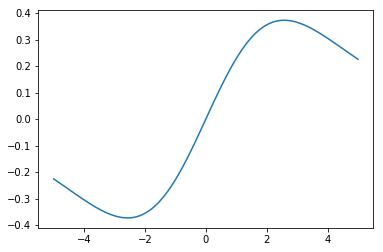

In [20]:
def g(a,w):
    return(w*sigmoid_prime(a*w))


a = 0.6
x_axis = np.linspace(-5, 5, 100)
a_array = np.array([a for i in range(100)])
g_values = g(a_array, x_axis)

plt.plot(x_axis, g_values)

we are looking for the values of $a$ such that $g_w(a) \geq 1$. First, we separate cases according to the sign of $w$. multiplying by the denominator and factoring leads to solving quadratic inequalities in $X := e^{-\frac 1 2 wa}$. We then look at the set of admissible values for X, from which we infer the set of values of $a$ (thanks to the monotonicity of $a \mapsto e^{-\frac 1 2 wa}$) that work out. This set is an interval, the size of which is smaller than $$\frac 2 {|w|}  ln \big( \frac {|w|(1+\sqrt{1-4/|w|})} {2} -1 \big)$$

which is itself smaller than $0.45$. Therefore  few values of $a$ allow gradient explosion.



Instability is problematic in most deep neural networks, not just in this toy example. The main difference is that the calculations are more tedious, and involve the matrix based approach to backpropagation. 

# III. Other obstacles to deep learning

* **Sigmoid neurons** are [likely](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) to lead to a **learning slowdown** in the **final hidden layer** due to **saturation** of activations to $0$
* **Initialization of weights** and **momentum schedule** have a [significant impact](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf) on deep network performance


Many factors influence learning in deep neural networks. This means that there are many different ways to improve learning. This will be the subject of the following chapter.